In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, sqrt,pi
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [2]:

start = 0.
end = 1.

x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

xb1 = np.linspace(start,start, 100 )
yb1 = np.linspace(start,end, 100 ) 
xb1 = xb1.reshape(-1, 1)
yb1 = yb1.reshape(-1, 1)

xb2 = np.linspace(start,end, 100 )
yb2 = np.linspace(end,end, 100 ) 
xb2 = xb2.reshape(-1, 1)
yb2 = yb2.reshape(-1, 1)

xb3 = np.linspace(end,end, 100 )
yb3 = np.linspace(start,end, 100 ) 
xb3 = xb3.reshape(-1, 1)
yb3 = yb3.reshape(-1, 1)

xb4 = np.linspace(start,end, 100 )
yb4 = np.linspace(start,start, 100 ) 
xb4 = xb4.reshape(-1, 1)
yb4 = yb4.reshape(-1, 1)

xb = [xb1,xb2,xb3,xb4]
yb = [yb1,yb2,yb3,yb4]

def actual_soln(eps):
    p = 1 - np.exp(-1/eps);q = 1 + np.exp(-1/eps);d = 1/(q - 2*eps*p)
    return (np.sin(np.pi*x) + (eps*np.pi/p)*(np.exp(-x/eps) + np.exp((x-1)/eps) - q) ) * (2*y*(1 - y**2) + eps * ( p*d*(1-2*y) - 3*q/p + (3/p - d)*np.exp(-y/eps) + (3/p + d)*np.exp((y-1)/eps)))


In [3]:
def plot_graph(soln,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln.reshape(100,100))
    plt.title(soln_name)
    plt.show()

class Swish(nn.Module):
	def __init__(self, inplace=True):
		super(Swish, self).__init__()
		self.inplace = inplace

	def forward(self, x):
		if self.inplace:
			x.mul_(torch.sigmoid(x))
			return x
		else:
			return x * torch.sigmoid(x)
	

class PINN(nn.Module):
	hid_dim = 128
	input_dim = 2 
	def __init__(self):
		super(PINN, self).__init__()
		self.tanh = nn.Tanh()
		self.lin0 = nn.Linear(self.input_dim,self.hid_dim)
		self.lin = nn.Linear(self.hid_dim,self.hid_dim)
		self.lin1 = nn.Linear(self.hid_dim,1)
		self.swish = Swish()
	def forward(self,x):		
		x = self.lin0(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin1(x)
		return x


In [4]:
def train(device,x,y,xb,yb,eps,learning_rate,epochs,batch_flag,batch_size):
	xnet = torch.Tensor(x).to(device)
	ynet = torch.Tensor(y).to(device) 
	xb1,xb2,xb3,xb4 = xb
	yb1,yb2,yb3,yb4 = yb
	xb1 = torch.Tensor(xb1).to(device) 	
	yb1 = torch.Tensor(yb1).to(device) 
	xb2 = torch.Tensor(xb2).to(device) 	
	yb2 = torch.Tensor(yb2).to(device) 
	xb3 = torch.Tensor(xb3).to(device) 	
	yb3 = torch.Tensor(yb3).to(device) 
	xb4 = torch.Tensor(xb4).to(device) 	
	yb4 = torch.Tensor(yb4).to(device) 

	if(batch_flag):
		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
	
	net = PINN().to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)

		U = U.view(len(U),-1)

		p = 1 - np.exp(-1/eps);q = 1 + np.exp(-1/eps);d = 1/(q - 2*eps*p)
		
		soln = (torch.sin(np.pi*xnet) + (eps*np.pi/p)*(torch.exp(-xnet/eps) + torch.exp((xnet-1)/eps) - q) ) * (2*ynet*(1 - ynet*ynet) + eps * ( p*d*(1-2*ynet) - 3*q/p + (3/p - d)*torch.exp(-ynet/eps) + (3/p + d)*torch.exp((ynet-1)/eps)))
		
		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]

		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)

		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	def Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4):
		
		xb1.requires_grad = True
		yb1.requires_grad = True
		xb2.requires_grad = True
		yb2.requires_grad = True
		xb3.requires_grad = True
		yb3.requires_grad = True
		xb4.requires_grad = True
		yb4.requires_grad = True
	
		loss_f = nn.MSELoss()


		net1 = torch.cat((xb1, yb1), 1)
		out1 = net(net1)
		ub1 = out1.view(len(out1), -1)
		der_ub1 = torch.autograd.grad(ub1,xb1,grad_outputs=torch.ones_like(xb1),create_graph = True,only_inputs=True)[0]

		loss_dirichlet1 = loss_f(ub1,torch.zeros_like(ub1))
		loss_neumann1 = loss_f(der_ub1,torch.zeros_like(der_ub1))

		net2 = torch.cat((xb2, yb2), 1)
		out2 = net(net2)
		ub2 = out2.view(len(out2), -1)
		der_ub2 = torch.autograd.grad(ub2,yb2,grad_outputs=torch.ones_like(yb2),create_graph = True,only_inputs=True)[0]

		loss_dirichlet2 = loss_f(ub2,torch.zeros_like(ub2))
		loss_neumann2 = loss_f(der_ub2,torch.zeros_like(der_ub2))

		net3 = torch.cat((xb3, yb3), 1)
		out3 = net(net3)
		ub3 = out3.view(len(out3), -1)
		der_ub3 = torch.autograd.grad(ub3,xb3,grad_outputs=torch.ones_like(xb3),create_graph = True,only_inputs=True)[0]

		loss_dirichlet3 = loss_f(ub3,torch.zeros_like(ub3))
		loss_neumann3 = loss_f(der_ub3,torch.zeros_like(der_ub3))

		net4 = torch.cat((xb4, yb4), 1)
		out4 = net(net4)
		ub4 = out4.view(len(out4), -1)
		der_ub4 = torch.autograd.grad(ub4,yb4,grad_outputs=torch.ones_like(yb4),create_graph = True,only_inputs=True)[0]

		loss_dirichlet4 = loss_f(ub4,torch.zeros_like(ub4))
		loss_neumann4 = loss_f(der_ub4,torch.zeros_like(der_ub4))

		total_loss = loss_dirichlet1 + loss_neumann1 + loss_dirichlet2 + loss_neumann2 + loss_dirichlet3 + loss_neumann3 + loss_dirichlet4 + loss_neumann4 
		return total_loss

	losses = [];errors = []
	tic = time.time()


	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 50:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss_eqn = Loss_criterion(x_in,y_in)
				loss_bc = Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4)
				loss = loss_eqn + 10*loss_bc
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('Train Epoch: {} \nTotal Loss: {:.10f} \tCriterion Loss: {:.10f} \tBoundary Condition Loss {:.6f}'.format(
					epoch, loss.item(),loss_eqn.item(),loss_bc.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				plot_graph(z,'Predicted solution')
			losses.append(loss.item())
			errors.append(actual_loss)
	else:
		for epoch in range(epochs):
			if epoch == 100:
				learning_rate = 0.0001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer

			net.zero_grad()
			loss_eqn = Loss_criterion(xnet,ynet)
			loss_bc = Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4)
			loss = loss_eqn + loss_bc
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			if epoch % 5 == 0:
				plot_graph(z,"soln")
			print('Train Epoch: {} \nTotal Loss: {:.10f} \tCriterion Loss: {:.10f} \tBoundary Condition Loss {:.6f}\nActual loss: {:.6f}'.format(
				epoch, loss.item(),loss_eqn.item(),loss_bc.item(),actual_loss))
			losses.append(loss.item())
			errors.append(actual_loss)
	toc = time.time()
	elapseTime = toc - tic
	print ("elapse time in parallel = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output,losses,errors 

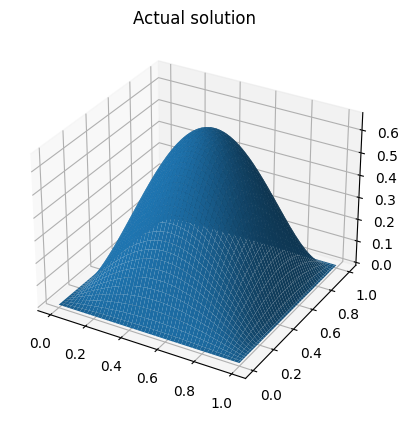

In [5]:
eps = 0.02
plot_graph(actual_soln(eps),'Actual solution')

0.02
Train Epoch: 0 
Total Loss: 62.4951057434 	Criterion Loss: 33.7467269897 	Boundary Condition Loss 2.874838
Train Epoch: 0 
Total Loss: 33.8732643127 	Criterion Loss: 21.1698932648 	Boundary Condition Loss 1.270337
Train Epoch: 0 
Total Loss: 32.5618286133 	Criterion Loss: 21.9887428284 	Boundary Condition Loss 1.057309
Train Epoch: 0 
Total Loss: 30.0292129517 	Criterion Loss: 21.1607818604 	Boundary Condition Loss 0.886843

After Epoch 0, 	 Actual solution loss: 0.0311131582



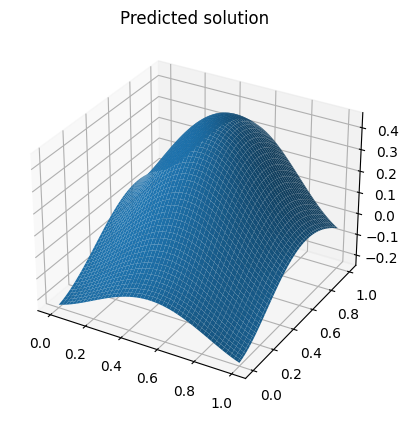

Train Epoch: 1 
Total Loss: 31.1946487427 	Criterion Loss: 21.0160217285 	Boundary Condition Loss 1.017863
Train Epoch: 1 
Total Loss: 29.5646286011 	Criterion Loss: 19.8521671295 	Boundary Condition Loss 0.971246
Train Epoch: 1 
Total Loss: 29.1659717560 	Criterion Loss: 20.2170333862 	Boundary Condition Loss 0.894894
Train Epoch: 1 
Total Loss: 29.3109092712 	Criterion Loss: 19.9967613220 	Boundary Condition Loss 0.931415

After Epoch 1, 	 Actual solution loss: 0.0255066490



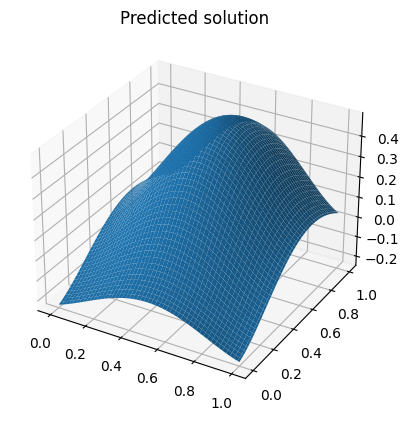

Train Epoch: 2 
Total Loss: 30.5179061890 	Criterion Loss: 20.9566173553 	Boundary Condition Loss 0.956129
Train Epoch: 2 
Total Loss: 28.8559722900 	Criterion Loss: 19.9486274719 	Boundary Condition Loss 0.890734
Train Epoch: 2 
Total Loss: 31.6769523621 	Criterion Loss: 21.5362911224 	Boundary Condition Loss 1.014066
Train Epoch: 2 
Total Loss: 28.5310592651 	Criterion Loss: 19.9729232788 	Boundary Condition Loss 0.855814

After Epoch 2, 	 Actual solution loss: 0.0426166266



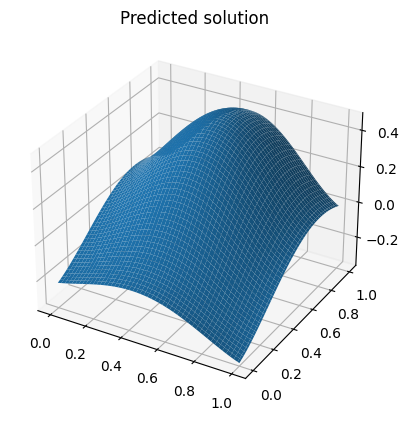

Train Epoch: 3 
Total Loss: 30.4758205414 	Criterion Loss: 21.1087589264 	Boundary Condition Loss 0.936706
Train Epoch: 3 
Total Loss: 31.2935638428 	Criterion Loss: 22.6270732880 	Boundary Condition Loss 0.866649
Train Epoch: 3 
Total Loss: 30.1960945129 	Criterion Loss: 21.2016582489 	Boundary Condition Loss 0.899444
Train Epoch: 3 
Total Loss: 30.0055427551 	Criterion Loss: 21.2979373932 	Boundary Condition Loss 0.870761

After Epoch 3, 	 Actual solution loss: 0.0286463166



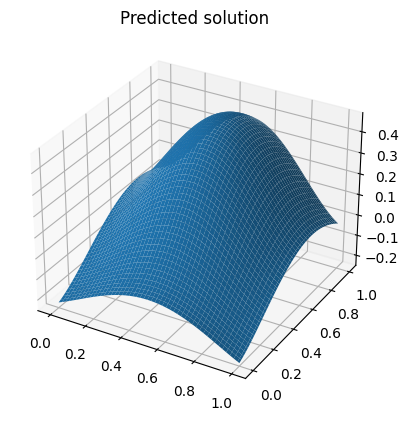

Train Epoch: 4 
Total Loss: 29.5374717712 	Criterion Loss: 20.2325534821 	Boundary Condition Loss 0.930492
Train Epoch: 4 
Total Loss: 29.2432098389 	Criterion Loss: 20.3825912476 	Boundary Condition Loss 0.886062
Train Epoch: 4 
Total Loss: 28.8460102081 	Criterion Loss: 20.8230552673 	Boundary Condition Loss 0.802296
Train Epoch: 4 
Total Loss: 31.5488014221 	Criterion Loss: 22.3067531586 	Boundary Condition Loss 0.924205

After Epoch 4, 	 Actual solution loss: 0.0267573323



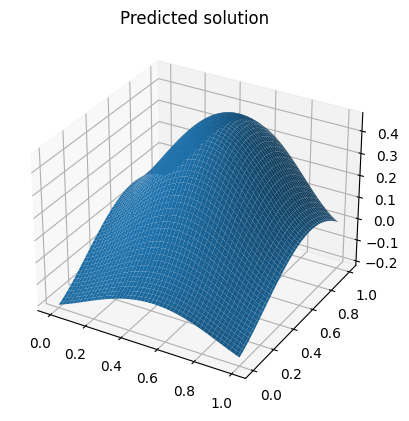

Train Epoch: 5 
Total Loss: 30.5670318604 	Criterion Loss: 21.5618286133 	Boundary Condition Loss 0.900520
Train Epoch: 5 
Total Loss: 28.5135211945 	Criterion Loss: 19.1505317688 	Boundary Condition Loss 0.936299
Train Epoch: 5 
Total Loss: 30.5351486206 	Criterion Loss: 21.9781551361 	Boundary Condition Loss 0.855699
Train Epoch: 5 
Total Loss: 29.6279373169 	Criterion Loss: 20.1968173981 	Boundary Condition Loss 0.943112

After Epoch 5, 	 Actual solution loss: 0.0256743786



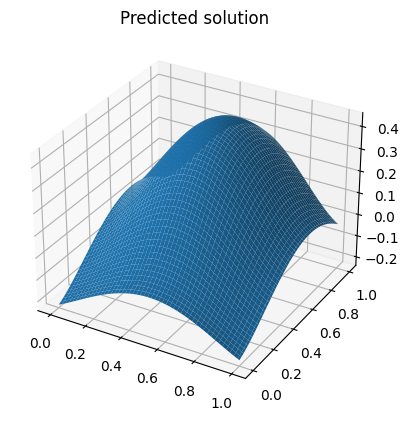

Train Epoch: 6 
Total Loss: 29.4303779602 	Criterion Loss: 19.5533180237 	Boundary Condition Loss 0.987706
Train Epoch: 6 
Total Loss: 31.1217308044 	Criterion Loss: 20.0594654083 	Boundary Condition Loss 1.106227
Train Epoch: 6 
Total Loss: 29.6251029968 	Criterion Loss: 20.0291786194 	Boundary Condition Loss 0.959592
Train Epoch: 6 
Total Loss: 30.3988704681 	Criterion Loss: 20.5329875946 	Boundary Condition Loss 0.986588

After Epoch 6, 	 Actual solution loss: 0.0244658656



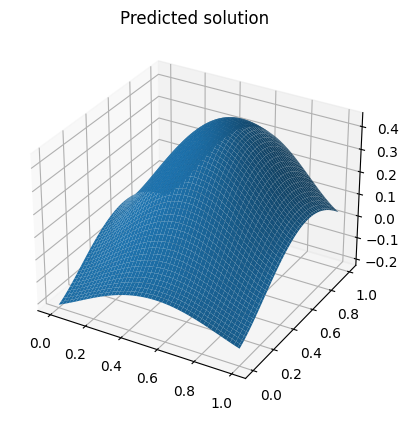

Train Epoch: 7 
Total Loss: 31.6627426147 	Criterion Loss: 22.2407836914 	Boundary Condition Loss 0.942196
Train Epoch: 7 
Total Loss: 30.1921787262 	Criterion Loss: 21.4788894653 	Boundary Condition Loss 0.871329
Train Epoch: 7 
Total Loss: 32.7716789246 	Criterion Loss: 24.4470653534 	Boundary Condition Loss 0.832461
Train Epoch: 7 
Total Loss: 29.1227588654 	Criterion Loss: 20.6927223206 	Boundary Condition Loss 0.843004

After Epoch 7, 	 Actual solution loss: 0.0251546219



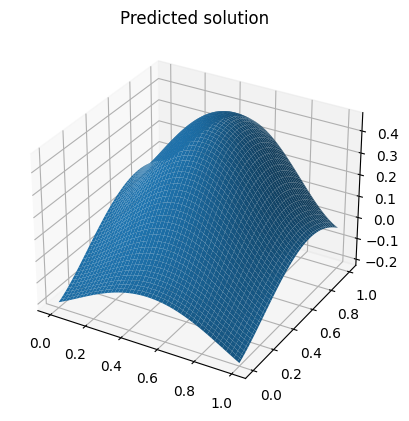

Train Epoch: 8 
Total Loss: 32.8110580444 	Criterion Loss: 23.8352775574 	Boundary Condition Loss 0.897578
Train Epoch: 8 
Total Loss: 34.2104797363 	Criterion Loss: 27.4226970673 	Boundary Condition Loss 0.678778
Train Epoch: 8 
Total Loss: 29.1947460175 	Criterion Loss: 20.9910602570 	Boundary Condition Loss 0.820369
Train Epoch: 8 
Total Loss: 29.7834663391 	Criterion Loss: 20.3923263550 	Boundary Condition Loss 0.939114

After Epoch 8, 	 Actual solution loss: 0.0300318972



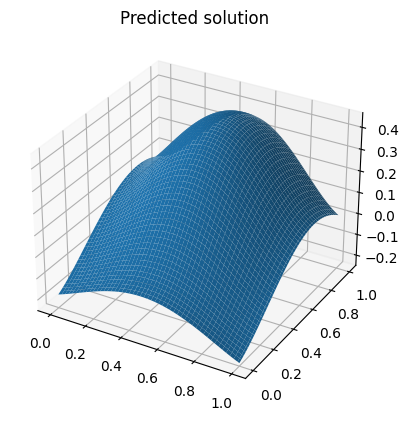

Train Epoch: 9 
Total Loss: 29.8890151978 	Criterion Loss: 22.3466415405 	Boundary Condition Loss 0.754237
Train Epoch: 9 
Total Loss: 29.8710842133 	Criterion Loss: 19.7548294067 	Boundary Condition Loss 1.011626
Train Epoch: 9 
Total Loss: 30.6301174164 	Criterion Loss: 22.1039237976 	Boundary Condition Loss 0.852619
Train Epoch: 9 
Total Loss: 29.8434524536 	Criterion Loss: 20.4647350311 	Boundary Condition Loss 0.937872

After Epoch 9, 	 Actual solution loss: 0.0324447539



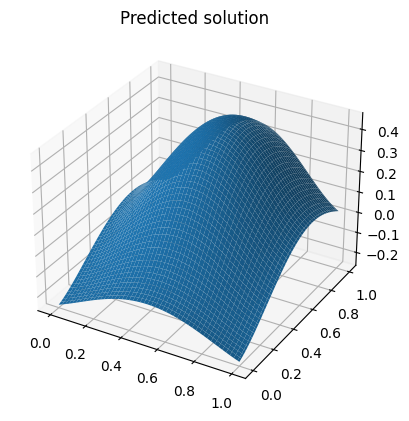

Train Epoch: 10 
Total Loss: 30.6483917236 	Criterion Loss: 22.5054492950 	Boundary Condition Loss 0.814294
Train Epoch: 10 
Total Loss: 28.7796554565 	Criterion Loss: 19.5136871338 	Boundary Condition Loss 0.926597
Train Epoch: 10 
Total Loss: 38.2278862000 	Criterion Loss: 27.7512588501 	Boundary Condition Loss 1.047663
Train Epoch: 10 
Total Loss: 29.8957881927 	Criterion Loss: 20.5845966339 	Boundary Condition Loss 0.931119

After Epoch 10, 	 Actual solution loss: 0.0293110087



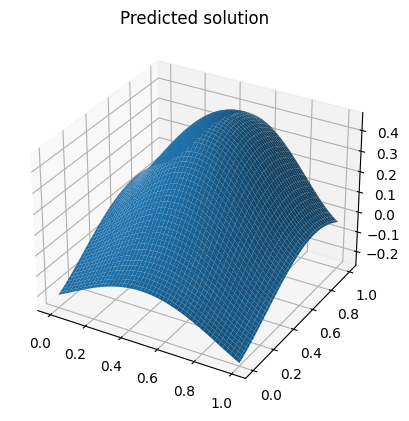

Train Epoch: 11 
Total Loss: 30.0675888062 	Criterion Loss: 20.7147197723 	Boundary Condition Loss 0.935287
Train Epoch: 11 
Total Loss: 29.0867767334 	Criterion Loss: 19.9214096069 	Boundary Condition Loss 0.916537
Train Epoch: 11 
Total Loss: 30.4306106567 	Criterion Loss: 20.5023059845 	Boundary Condition Loss 0.992830
Train Epoch: 11 
Total Loss: 30.1675567627 	Criterion Loss: 20.5241527557 	Boundary Condition Loss 0.964340

After Epoch 11, 	 Actual solution loss: 0.0323714303



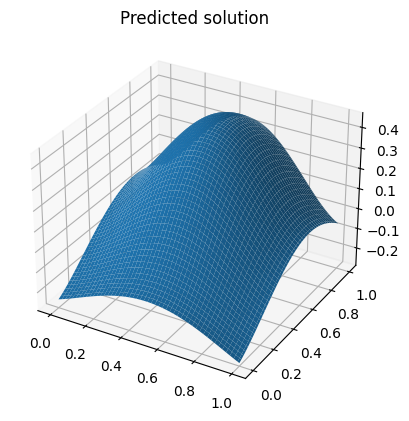

Train Epoch: 12 
Total Loss: 29.5419960022 	Criterion Loss: 19.9044227600 	Boundary Condition Loss 0.963757
Train Epoch: 12 
Total Loss: 30.6411876678 	Criterion Loss: 21.9272537231 	Boundary Condition Loss 0.871393
Train Epoch: 12 
Total Loss: 31.1326332092 	Criterion Loss: 21.5974502563 	Boundary Condition Loss 0.953518
Train Epoch: 12 
Total Loss: 29.5272197723 	Criterion Loss: 20.7102184296 	Boundary Condition Loss 0.881700

After Epoch 12, 	 Actual solution loss: 0.0274520093



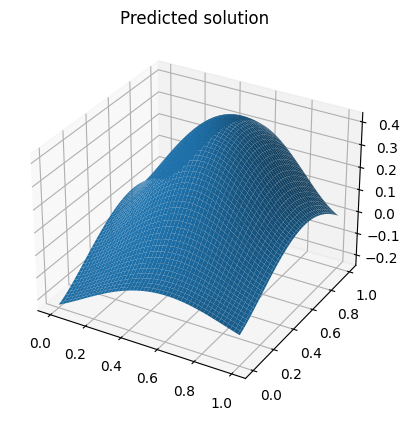

Train Epoch: 13 
Total Loss: 28.2308731079 	Criterion Loss: 20.9051551819 	Boundary Condition Loss 0.732572
Train Epoch: 13 
Total Loss: 29.7018070221 	Criterion Loss: 20.3117218018 	Boundary Condition Loss 0.939008
Train Epoch: 13 
Total Loss: 28.9046401978 	Criterion Loss: 19.4029541016 	Boundary Condition Loss 0.950168
Train Epoch: 13 
Total Loss: 29.9052162170 	Criterion Loss: 21.7287578583 	Boundary Condition Loss 0.817646

After Epoch 13, 	 Actual solution loss: 0.0294748543



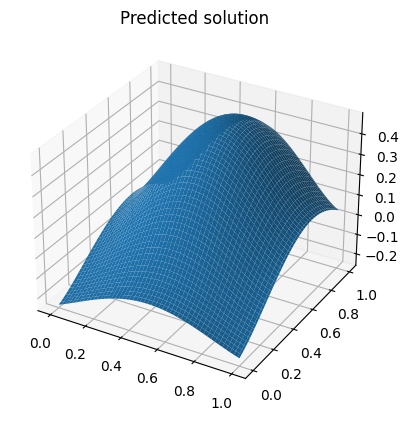

Train Epoch: 14 
Total Loss: 29.2846603394 	Criterion Loss: 19.1812095642 	Boundary Condition Loss 1.010345
Train Epoch: 14 
Total Loss: 29.6126098633 	Criterion Loss: 20.7519435883 	Boundary Condition Loss 0.886066
Train Epoch: 14 
Total Loss: 29.9655456543 	Criterion Loss: 20.7094001770 	Boundary Condition Loss 0.925615
Train Epoch: 14 
Total Loss: 31.3030204773 	Criterion Loss: 20.1907920837 	Boundary Condition Loss 1.111223

After Epoch 14, 	 Actual solution loss: 0.0251822728



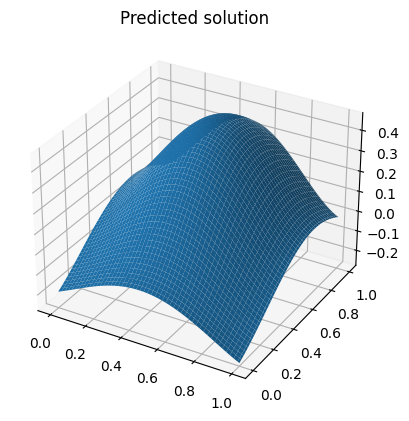

Train Epoch: 15 
Total Loss: 30.2754211426 	Criterion Loss: 20.9295921326 	Boundary Condition Loss 0.934583
Train Epoch: 15 
Total Loss: 29.6389160156 	Criterion Loss: 19.9941692352 	Boundary Condition Loss 0.964475
Train Epoch: 15 
Total Loss: 28.8196678162 	Criterion Loss: 18.9218921661 	Boundary Condition Loss 0.989778
Train Epoch: 15 
Total Loss: 29.1666088104 	Criterion Loss: 18.6878719330 	Boundary Condition Loss 1.047874

After Epoch 15, 	 Actual solution loss: 0.0351899934



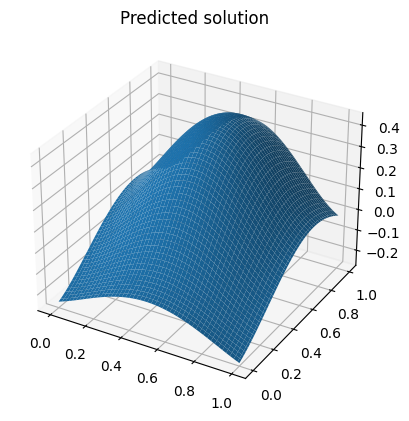

Train Epoch: 16 
Total Loss: 28.9100360870 	Criterion Loss: 21.0700073242 	Boundary Condition Loss 0.784003
Train Epoch: 16 
Total Loss: 29.9590072632 	Criterion Loss: 21.2926769257 	Boundary Condition Loss 0.866633
Train Epoch: 16 
Total Loss: 29.0657081604 	Criterion Loss: 19.0247421265 	Boundary Condition Loss 1.004097
Train Epoch: 16 
Total Loss: 31.8726272583 	Criterion Loss: 22.0161914825 	Boundary Condition Loss 0.985644

After Epoch 16, 	 Actual solution loss: 0.0265877384



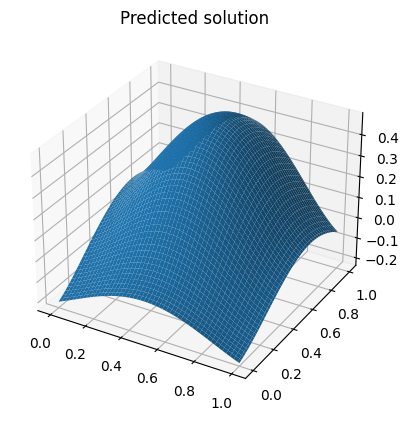

Train Epoch: 17 
Total Loss: 29.5412635803 	Criterion Loss: 19.6388664246 	Boundary Condition Loss 0.990240
Train Epoch: 17 
Total Loss: 29.7754096985 	Criterion Loss: 19.4725837708 	Boundary Condition Loss 1.030283
Train Epoch: 17 
Total Loss: 29.3716812134 	Criterion Loss: 20.7940044403 	Boundary Condition Loss 0.857768
Train Epoch: 17 
Total Loss: 29.4951362610 	Criterion Loss: 20.6837348938 	Boundary Condition Loss 0.881140

After Epoch 17, 	 Actual solution loss: 0.0289156050



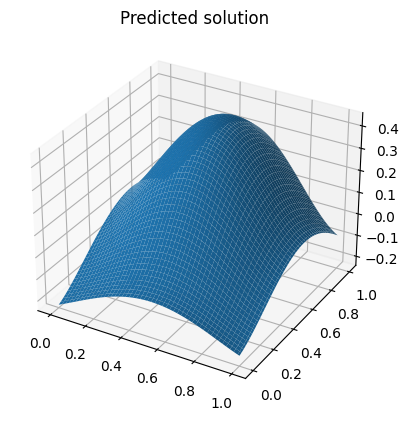

Train Epoch: 18 
Total Loss: 30.6539440155 	Criterion Loss: 21.6337127686 	Boundary Condition Loss 0.902023
Train Epoch: 18 
Total Loss: 29.2028884888 	Criterion Loss: 21.2678909302 	Boundary Condition Loss 0.793500
Train Epoch: 18 
Total Loss: 31.6219940186 	Criterion Loss: 21.7940807343 	Boundary Condition Loss 0.982791
Train Epoch: 18 
Total Loss: 29.4285049438 	Criterion Loss: 20.7163963318 	Boundary Condition Loss 0.871211

After Epoch 18, 	 Actual solution loss: 0.0238284625



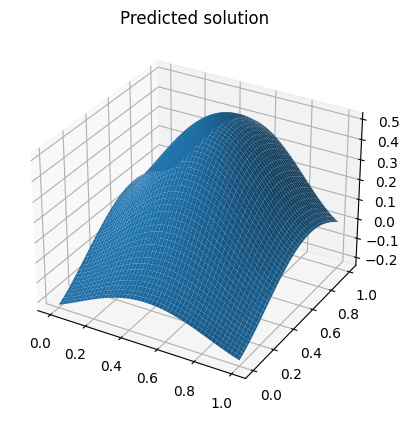

Train Epoch: 19 
Total Loss: 29.3408088684 	Criterion Loss: 19.0115509033 	Boundary Condition Loss 1.032926
Train Epoch: 19 
Total Loss: 29.8364543915 	Criterion Loss: 19.5533733368 	Boundary Condition Loss 1.028308
Train Epoch: 19 
Total Loss: 30.8358573914 	Criterion Loss: 19.6189041138 	Boundary Condition Loss 1.121695
Train Epoch: 19 
Total Loss: 29.9513168335 	Criterion Loss: 23.0892791748 	Boundary Condition Loss 0.686204

After Epoch 19, 	 Actual solution loss: 0.0323041447



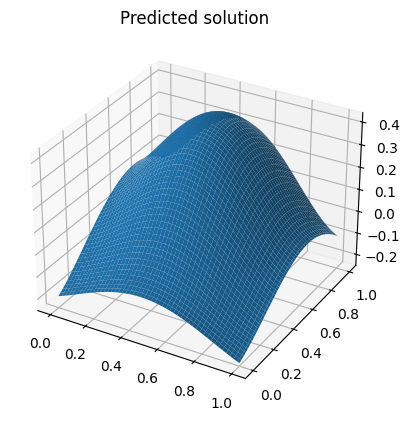

Train Epoch: 20 
Total Loss: 28.8751983643 	Criterion Loss: 20.4238185883 	Boundary Condition Loss 0.845138
Train Epoch: 20 
Total Loss: 30.4185714722 	Criterion Loss: 20.3623962402 	Boundary Condition Loss 1.005618
Train Epoch: 20 
Total Loss: 30.8385543823 	Criterion Loss: 21.1536216736 	Boundary Condition Loss 0.968493
Train Epoch: 20 
Total Loss: 29.1466007233 	Criterion Loss: 18.5728492737 	Boundary Condition Loss 1.057375

After Epoch 20, 	 Actual solution loss: 0.0273724624



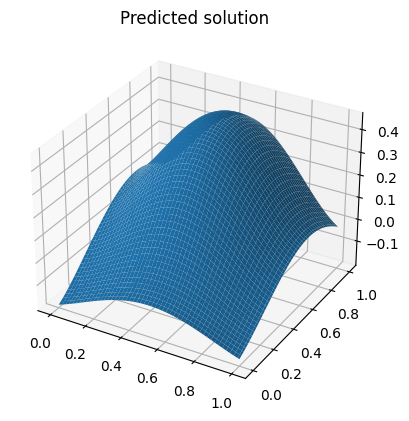

Train Epoch: 21 
Total Loss: 29.5207443237 	Criterion Loss: 21.8114089966 	Boundary Condition Loss 0.770934
Train Epoch: 21 
Total Loss: 28.7158508301 	Criterion Loss: 18.6831855774 	Boundary Condition Loss 1.003267
Train Epoch: 21 
Total Loss: 33.4283752441 	Criterion Loss: 27.0150127411 	Boundary Condition Loss 0.641336
Train Epoch: 21 
Total Loss: 30.6371994019 	Criterion Loss: 21.3322849274 	Boundary Condition Loss 0.930491

After Epoch 21, 	 Actual solution loss: 0.0275277058



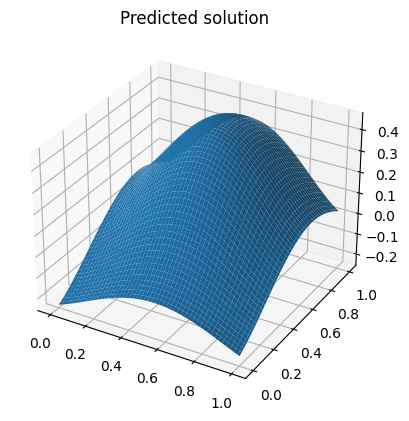

Train Epoch: 22 
Total Loss: 31.0853843689 	Criterion Loss: 21.5667972565 	Boundary Condition Loss 0.951859
Train Epoch: 22 
Total Loss: 32.3267898560 	Criterion Loss: 23.9049434662 	Boundary Condition Loss 0.842185
Train Epoch: 22 
Total Loss: 30.2520771027 	Criterion Loss: 20.8766059875 	Boundary Condition Loss 0.937547
Train Epoch: 22 
Total Loss: 29.0010204315 	Criterion Loss: 19.2367286682 	Boundary Condition Loss 0.976429

After Epoch 22, 	 Actual solution loss: 0.0275895490



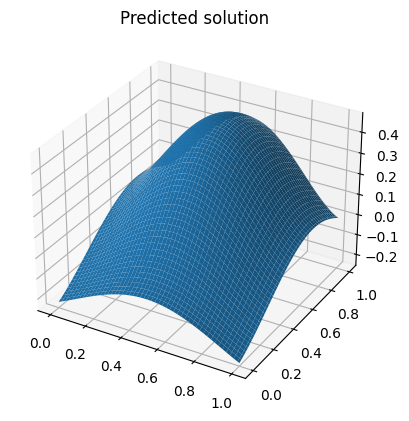

Train Epoch: 23 
Total Loss: 29.7952880859 	Criterion Loss: 20.2828807831 	Boundary Condition Loss 0.951241
Train Epoch: 23 
Total Loss: 29.1244812012 	Criterion Loss: 20.4906806946 	Boundary Condition Loss 0.863380
Train Epoch: 23 
Total Loss: 31.5145721436 	Criterion Loss: 22.5576858521 	Boundary Condition Loss 0.895689
Train Epoch: 23 
Total Loss: 28.6365203857 	Criterion Loss: 18.2525024414 	Boundary Condition Loss 1.038402

After Epoch 23, 	 Actual solution loss: 0.0301908559



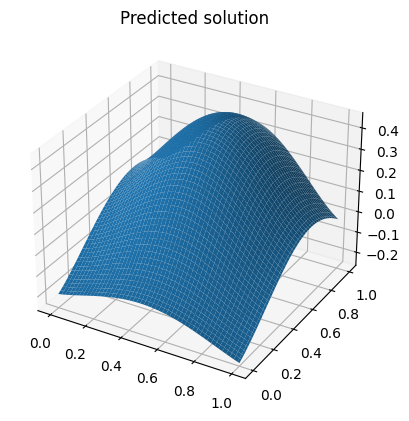

Train Epoch: 24 
Total Loss: 29.9682464600 	Criterion Loss: 19.7491817474 	Boundary Condition Loss 1.021906
Train Epoch: 24 
Total Loss: 31.0412311554 	Criterion Loss: 23.1856899261 	Boundary Condition Loss 0.785554
Train Epoch: 24 
Total Loss: 29.2270812988 	Criterion Loss: 19.7474079132 	Boundary Condition Loss 0.947967
Train Epoch: 24 
Total Loss: 29.3839778900 	Criterion Loss: 19.5754699707 	Boundary Condition Loss 0.980851

After Epoch 24, 	 Actual solution loss: 0.0296488030



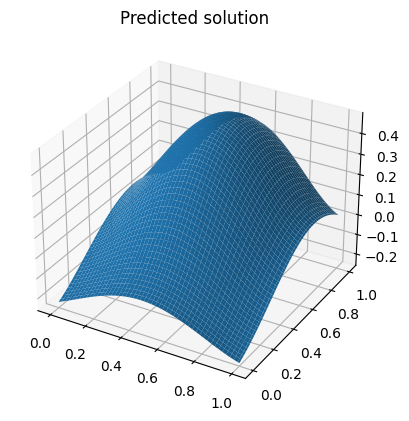

Train Epoch: 25 
Total Loss: 29.7007865906 	Criterion Loss: 19.9698467255 	Boundary Condition Loss 0.973094
Train Epoch: 25 
Total Loss: 30.2924880981 	Criterion Loss: 21.2528915405 	Boundary Condition Loss 0.903960
Train Epoch: 25 
Total Loss: 30.2257232666 	Criterion Loss: 21.5994606018 	Boundary Condition Loss 0.862626
Train Epoch: 25 
Total Loss: 28.3830776215 	Criterion Loss: 20.2465019226 	Boundary Condition Loss 0.813658

After Epoch 25, 	 Actual solution loss: 0.0306313849



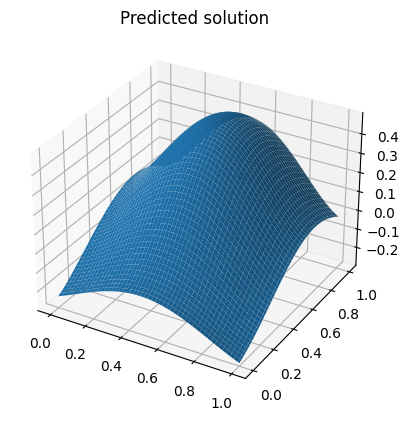

Train Epoch: 26 
Total Loss: 30.0567302704 	Criterion Loss: 19.6103267670 	Boundary Condition Loss 1.044640
Train Epoch: 26 
Total Loss: 29.1171302795 	Criterion Loss: 20.6713027954 	Boundary Condition Loss 0.844583
Train Epoch: 26 
Total Loss: 30.3828430176 	Criterion Loss: 20.9743213654 	Boundary Condition Loss 0.940852
Train Epoch: 26 
Total Loss: 34.1755828857 	Criterion Loss: 26.1843433380 	Boundary Condition Loss 0.799124

After Epoch 26, 	 Actual solution loss: 0.0295131551



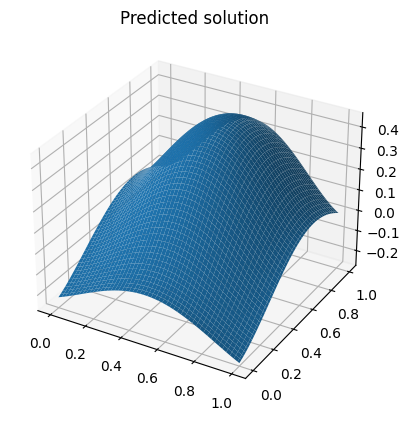

Train Epoch: 27 
Total Loss: 29.2641601562 	Criterion Loss: 20.5061836243 	Boundary Condition Loss 0.875798
Train Epoch: 27 
Total Loss: 28.6140518188 	Criterion Loss: 19.9639511108 	Boundary Condition Loss 0.865010
Train Epoch: 27 
Total Loss: 28.9092102051 	Criterion Loss: 19.8167152405 	Boundary Condition Loss 0.909249
Train Epoch: 27 
Total Loss: 30.2973556519 	Criterion Loss: 21.0250873566 	Boundary Condition Loss 0.927227

After Epoch 27, 	 Actual solution loss: 0.0259143870



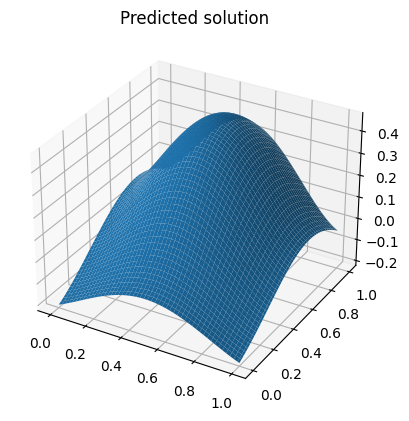

Train Epoch: 28 
Total Loss: 30.2705879211 	Criterion Loss: 21.6056499481 	Boundary Condition Loss 0.866494
Train Epoch: 28 
Total Loss: 29.8357658386 	Criterion Loss: 20.1318416595 	Boundary Condition Loss 0.970393
Train Epoch: 28 
Total Loss: 29.2232322693 	Criterion Loss: 19.3883457184 	Boundary Condition Loss 0.983489
Train Epoch: 28 
Total Loss: 30.3930377960 	Criterion Loss: 20.1362991333 	Boundary Condition Loss 1.025674

After Epoch 28, 	 Actual solution loss: 0.0303023965



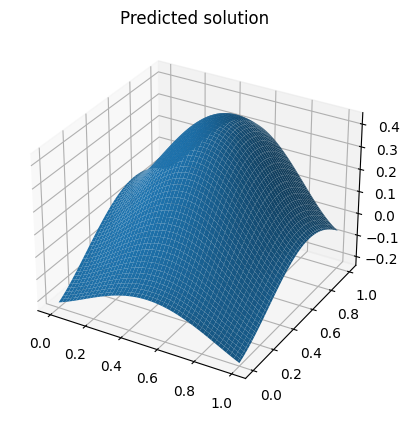

Train Epoch: 29 
Total Loss: 30.3179702759 	Criterion Loss: 22.2456703186 	Boundary Condition Loss 0.807230
Train Epoch: 29 
Total Loss: 30.1539325714 	Criterion Loss: 20.4277915955 	Boundary Condition Loss 0.972614
Train Epoch: 29 
Total Loss: 29.9680709839 	Criterion Loss: 21.6991977692 	Boundary Condition Loss 0.826887
Train Epoch: 29 
Total Loss: 30.7032470703 	Criterion Loss: 21.7189292908 	Boundary Condition Loss 0.898432

After Epoch 29, 	 Actual solution loss: 0.0273943850



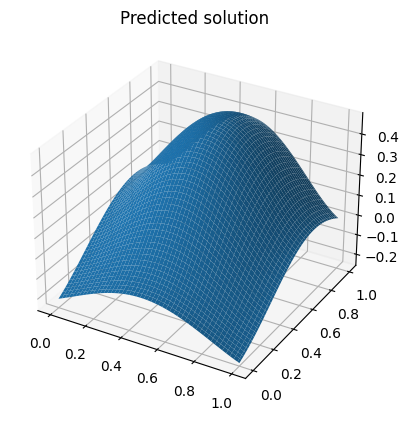

Train Epoch: 30 
Total Loss: 29.0236949921 	Criterion Loss: 19.2751045227 	Boundary Condition Loss 0.974859
Train Epoch: 30 
Total Loss: 28.5402126312 	Criterion Loss: 19.1892623901 	Boundary Condition Loss 0.935095
Train Epoch: 30 
Total Loss: 30.8270492554 	Criterion Loss: 23.1659793854 	Boundary Condition Loss 0.766107
Train Epoch: 30 
Total Loss: 30.0162906647 	Criterion Loss: 19.8472709656 	Boundary Condition Loss 1.016902

After Epoch 30, 	 Actual solution loss: 0.0271803563



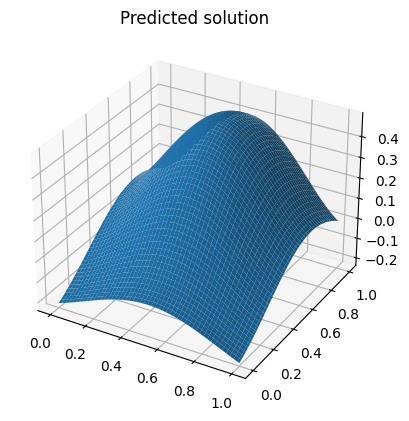

Train Epoch: 31 
Total Loss: 29.7914333344 	Criterion Loss: 20.4462928772 	Boundary Condition Loss 0.934514
Train Epoch: 31 
Total Loss: 29.2206001282 	Criterion Loss: 19.7016315460 	Boundary Condition Loss 0.951897
Train Epoch: 31 
Total Loss: 28.6570167542 	Criterion Loss: 19.9372043610 	Boundary Condition Loss 0.871981
Train Epoch: 31 
Total Loss: 29.6573371887 	Criterion Loss: 20.8053340912 	Boundary Condition Loss 0.885200

After Epoch 31, 	 Actual solution loss: 0.0292694485



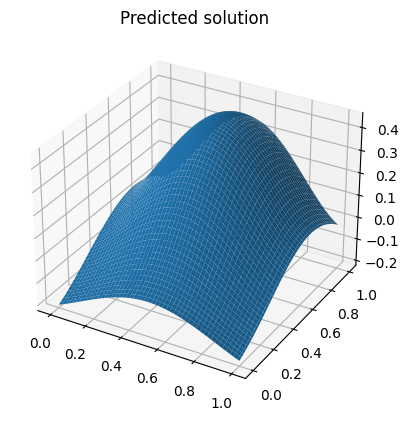

Train Epoch: 32 
Total Loss: 30.6142425537 	Criterion Loss: 21.9257736206 	Boundary Condition Loss 0.868847
Train Epoch: 32 
Total Loss: 29.3229618073 	Criterion Loss: 19.2224941254 	Boundary Condition Loss 1.010047
Train Epoch: 32 
Total Loss: 29.9099235535 	Criterion Loss: 20.6796398163 	Boundary Condition Loss 0.923028
Train Epoch: 32 
Total Loss: 29.4725608826 	Criterion Loss: 20.5344390869 	Boundary Condition Loss 0.893812

After Epoch 32, 	 Actual solution loss: 0.0218026078



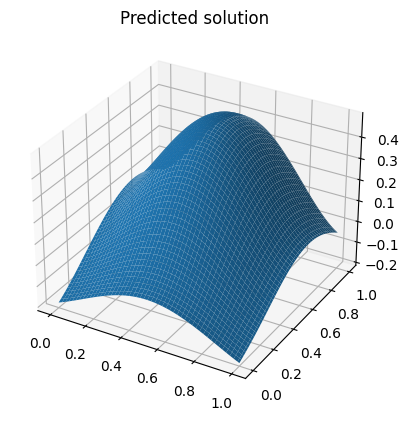

Train Epoch: 33 
Total Loss: 28.6312427521 	Criterion Loss: 19.2747879028 	Boundary Condition Loss 0.935645
Train Epoch: 33 
Total Loss: 29.9177856445 	Criterion Loss: 20.0463714600 	Boundary Condition Loss 0.987141
Train Epoch: 33 
Total Loss: 29.2892532349 	Criterion Loss: 21.3554801941 	Boundary Condition Loss 0.793377
Train Epoch: 33 
Total Loss: 28.7711982727 	Criterion Loss: 20.6100158691 	Boundary Condition Loss 0.816118

After Epoch 33, 	 Actual solution loss: 0.0300188406



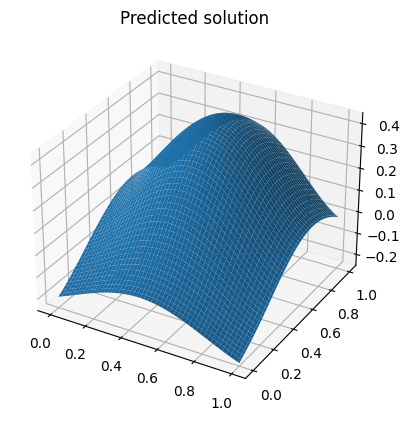

Train Epoch: 34 
Total Loss: 28.4638023376 	Criterion Loss: 19.5935783386 	Boundary Condition Loss 0.887022
Train Epoch: 34 
Total Loss: 35.8582344055 	Criterion Loss: 27.8756217957 	Boundary Condition Loss 0.798261
Train Epoch: 34 
Total Loss: 28.9073562622 	Criterion Loss: 19.4111633301 	Boundary Condition Loss 0.949619
Train Epoch: 34 
Total Loss: 29.2198333740 	Criterion Loss: 20.0909290314 	Boundary Condition Loss 0.912890

After Epoch 34, 	 Actual solution loss: 0.0263698517



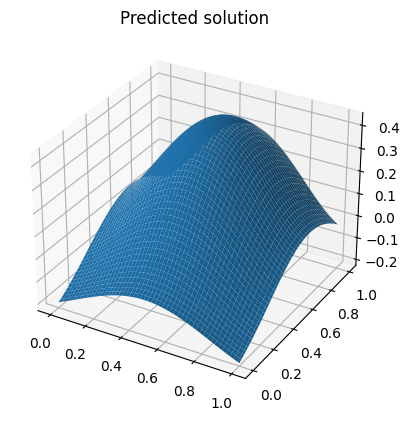

Train Epoch: 35 
Total Loss: 28.1662597656 	Criterion Loss: 18.8053741455 	Boundary Condition Loss 0.936089
Train Epoch: 35 
Total Loss: 29.6419563293 	Criterion Loss: 19.3776340485 	Boundary Condition Loss 1.026432
Train Epoch: 35 
Total Loss: 29.5913772583 	Criterion Loss: 20.6499729156 	Boundary Condition Loss 0.894140
Train Epoch: 35 
Total Loss: 30.7705860138 	Criterion Loss: 22.4860687256 	Boundary Condition Loss 0.828452

After Epoch 35, 	 Actual solution loss: 0.0303081686



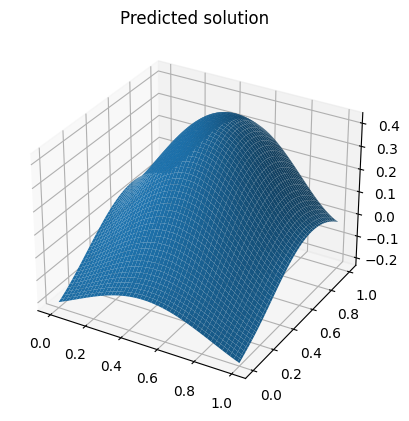

Train Epoch: 36 
Total Loss: 30.1317253113 	Criterion Loss: 21.4442310333 	Boundary Condition Loss 0.868750
Train Epoch: 36 
Total Loss: 28.9544525146 	Criterion Loss: 20.5304222107 	Boundary Condition Loss 0.842403
Train Epoch: 36 
Total Loss: 28.6771888733 	Criterion Loss: 19.6760196686 	Boundary Condition Loss 0.900117
Train Epoch: 36 
Total Loss: 29.9534931183 	Criterion Loss: 20.9965763092 	Boundary Condition Loss 0.895692

After Epoch 36, 	 Actual solution loss: 0.0312036244



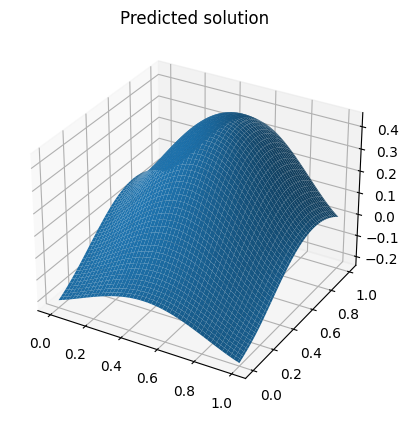

Train Epoch: 37 
Total Loss: 30.0411682129 	Criterion Loss: 21.5885334015 	Boundary Condition Loss 0.845264
Train Epoch: 37 
Total Loss: 29.0862731934 	Criterion Loss: 20.3223571777 	Boundary Condition Loss 0.876392
Train Epoch: 37 
Total Loss: 28.7864303589 	Criterion Loss: 20.0979652405 	Boundary Condition Loss 0.868847
Train Epoch: 37 
Total Loss: 29.2060279846 	Criterion Loss: 20.4324626923 	Boundary Condition Loss 0.877357

After Epoch 37, 	 Actual solution loss: 0.0302807823



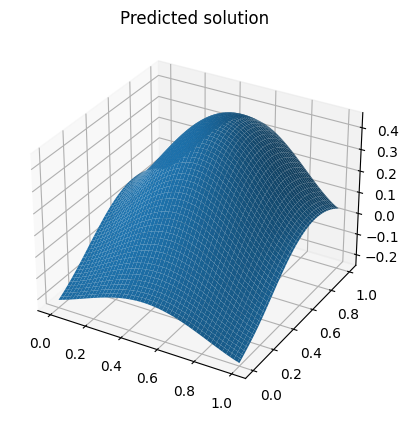

Train Epoch: 38 
Total Loss: 29.6110229492 	Criterion Loss: 21.3234062195 	Boundary Condition Loss 0.828762
Train Epoch: 38 
Total Loss: 29.0231304169 	Criterion Loss: 18.6551094055 	Boundary Condition Loss 1.036802
Train Epoch: 38 
Total Loss: 28.7459068298 	Criterion Loss: 18.4951782227 	Boundary Condition Loss 1.025073
Train Epoch: 38 
Total Loss: 29.0001583099 	Criterion Loss: 18.7141494751 	Boundary Condition Loss 1.028601

After Epoch 38, 	 Actual solution loss: 0.0247747864



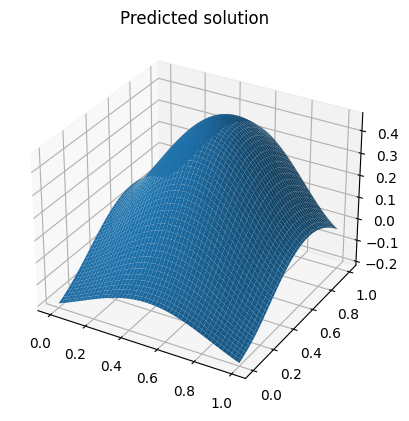

Train Epoch: 39 
Total Loss: 28.3788604736 	Criterion Loss: 19.4187469482 	Boundary Condition Loss 0.896011
Train Epoch: 39 
Total Loss: 28.7041130066 	Criterion Loss: 18.8908329010 	Boundary Condition Loss 0.981328
Train Epoch: 39 
Total Loss: 27.5912780762 	Criterion Loss: 18.4312191010 	Boundary Condition Loss 0.916006
Train Epoch: 39 
Total Loss: 29.4194164276 	Criterion Loss: 20.5603675842 	Boundary Condition Loss 0.885905

After Epoch 39, 	 Actual solution loss: 0.0308459804



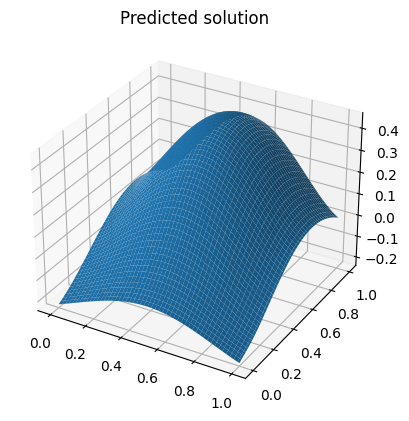

Train Epoch: 40 
Total Loss: 28.9964771271 	Criterion Loss: 19.7844772339 	Boundary Condition Loss 0.921200
Train Epoch: 40 
Total Loss: 30.6744995117 	Criterion Loss: 19.2651634216 	Boundary Condition Loss 1.140934
Train Epoch: 40 
Total Loss: 30.5645828247 	Criterion Loss: 20.0936012268 	Boundary Condition Loss 1.047098
Train Epoch: 40 
Total Loss: 28.2473125458 	Criterion Loss: 18.4348106384 	Boundary Condition Loss 0.981250

After Epoch 40, 	 Actual solution loss: 0.0296603295



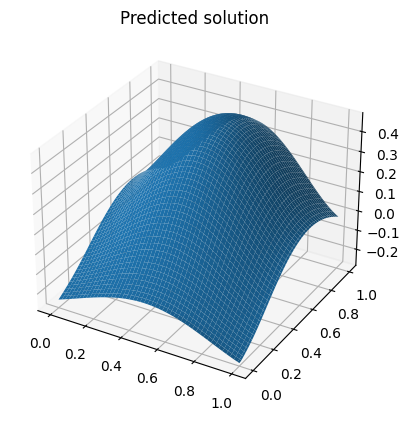

Train Epoch: 41 
Total Loss: 27.1601772308 	Criterion Loss: 18.0209598541 	Boundary Condition Loss 0.913922
Train Epoch: 41 
Total Loss: 28.1755580902 	Criterion Loss: 17.9491291046 	Boundary Condition Loss 1.022643
Train Epoch: 41 
Total Loss: 26.2675666809 	Criterion Loss: 15.9991941452 	Boundary Condition Loss 1.026837
Train Epoch: 41 
Total Loss: 23.7048873901 	Criterion Loss: 15.8189773560 	Boundary Condition Loss 0.788591

After Epoch 41, 	 Actual solution loss: 0.0401119637



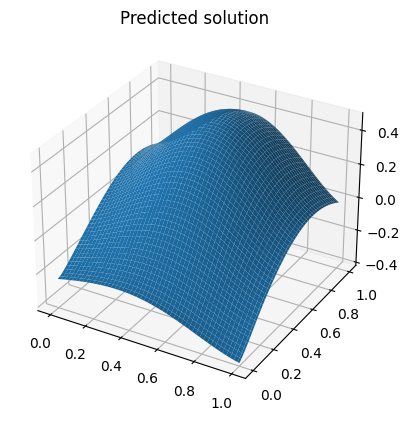

Train Epoch: 42 
Total Loss: 26.6711387634 	Criterion Loss: 17.1309356689 	Boundary Condition Loss 0.954020
Train Epoch: 42 
Total Loss: 23.5416679382 	Criterion Loss: 15.0659351349 	Boundary Condition Loss 0.847573
Train Epoch: 42 
Total Loss: 23.3901863098 	Criterion Loss: 14.1224632263 	Boundary Condition Loss 0.926772
Train Epoch: 42 
Total Loss: 22.9546318054 	Criterion Loss: 12.3389511108 	Boundary Condition Loss 1.061568

After Epoch 42, 	 Actual solution loss: 0.0561338990



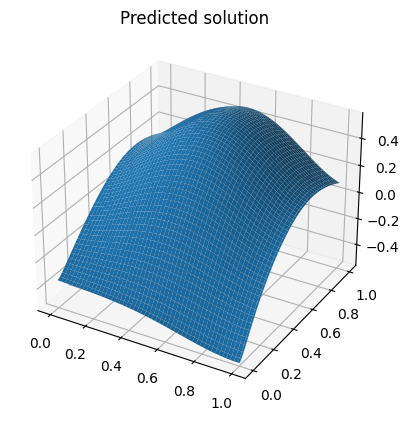

Train Epoch: 43 
Total Loss: 21.6182689667 	Criterion Loss: 12.4869146347 	Boundary Condition Loss 0.913135
Train Epoch: 43 
Total Loss: 21.7352008820 	Criterion Loss: 11.0496129990 	Boundary Condition Loss 1.068559
Train Epoch: 43 
Total Loss: 22.0768985748 	Criterion Loss: 11.9082889557 	Boundary Condition Loss 1.016861
Train Epoch: 43 
Total Loss: 24.9281692505 	Criterion Loss: 14.6067485809 	Boundary Condition Loss 1.032142

After Epoch 43, 	 Actual solution loss: 0.0647218001



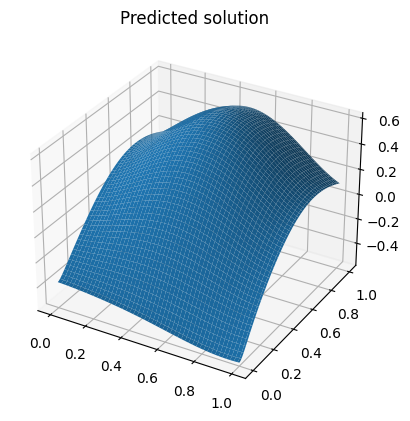

Train Epoch: 44 
Total Loss: 25.3403625488 	Criterion Loss: 14.3500022888 	Boundary Condition Loss 1.099036
Train Epoch: 44 
Total Loss: 21.3955612183 	Criterion Loss: 11.9696493149 	Boundary Condition Loss 0.942591
Train Epoch: 44 
Total Loss: 21.9003372192 	Criterion Loss: 11.1089143753 	Boundary Condition Loss 1.079142
Train Epoch: 44 
Total Loss: 20.9206352234 	Criterion Loss: 10.1160945892 	Boundary Condition Loss 1.080454

After Epoch 44, 	 Actual solution loss: 0.0640578948



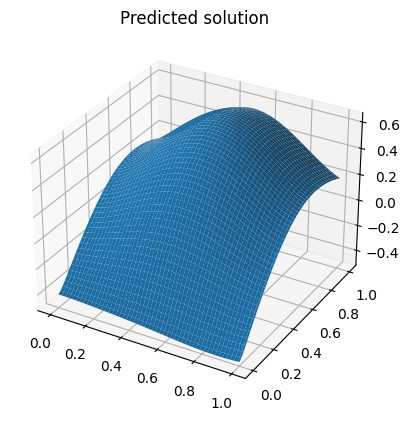

Train Epoch: 45 
Total Loss: 22.0297431946 	Criterion Loss: 11.5118417740 	Boundary Condition Loss 1.051790
Train Epoch: 45 
Total Loss: 21.4689407349 	Criterion Loss: 11.1242790222 	Boundary Condition Loss 1.034466
Train Epoch: 45 
Total Loss: 21.3322410583 	Criterion Loss: 10.5120887756 	Boundary Condition Loss 1.082015
Train Epoch: 45 
Total Loss: 20.9871749878 	Criterion Loss: 9.8442649841 	Boundary Condition Loss 1.114291

After Epoch 45, 	 Actual solution loss: 0.0706486732



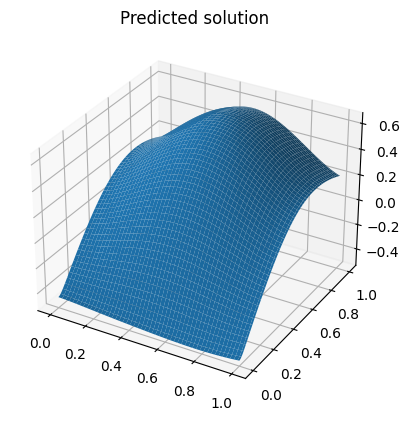

Train Epoch: 46 
Total Loss: 22.0860195160 	Criterion Loss: 11.4049701691 	Boundary Condition Loss 1.068105
Train Epoch: 46 
Total Loss: 21.5688877106 	Criterion Loss: 11.3420104980 	Boundary Condition Loss 1.022688
Train Epoch: 46 
Total Loss: 20.2505798340 	Criterion Loss: 10.0612792969 	Boundary Condition Loss 1.018930
Train Epoch: 46 
Total Loss: 21.5199012756 	Criterion Loss: 11.0126399994 	Boundary Condition Loss 1.050726

After Epoch 46, 	 Actual solution loss: 0.0678794158



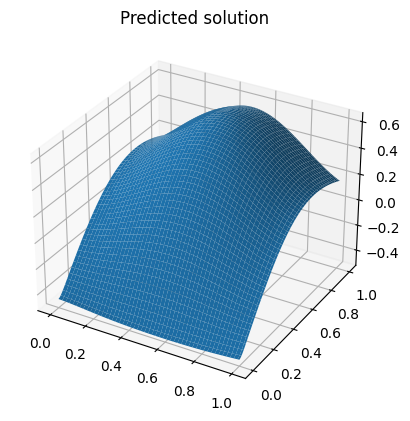

Train Epoch: 47 
Total Loss: 19.6722660065 	Criterion Loss: 9.2125320435 	Boundary Condition Loss 1.045973
Train Epoch: 47 
Total Loss: 21.7521514893 	Criterion Loss: 10.5295333862 	Boundary Condition Loss 1.122262
Train Epoch: 47 
Total Loss: 21.7924442291 	Criterion Loss: 11.5772809982 	Boundary Condition Loss 1.021516
Train Epoch: 47 
Total Loss: 21.8621330261 	Criterion Loss: 9.4938020706 	Boundary Condition Loss 1.236833

After Epoch 47, 	 Actual solution loss: 0.0638613448



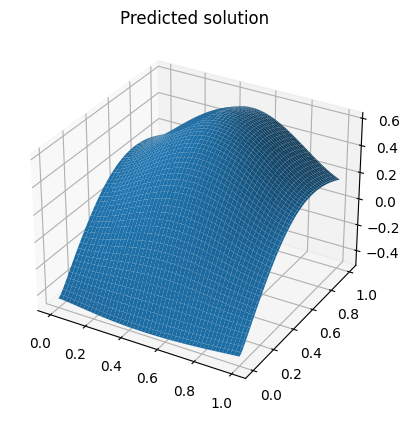

Train Epoch: 48 
Total Loss: 21.1803245544 	Criterion Loss: 11.8195743561 	Boundary Condition Loss 0.936075
Train Epoch: 48 
Total Loss: 19.9915924072 	Criterion Loss: 9.3526630402 	Boundary Condition Loss 1.063893
Train Epoch: 48 
Total Loss: 23.2007751465 	Criterion Loss: 11.3589935303 	Boundary Condition Loss 1.184178
Train Epoch: 48 
Total Loss: 21.2862796783 	Criterion Loss: 9.5333642960 	Boundary Condition Loss 1.175292

After Epoch 48, 	 Actual solution loss: 0.0738682279



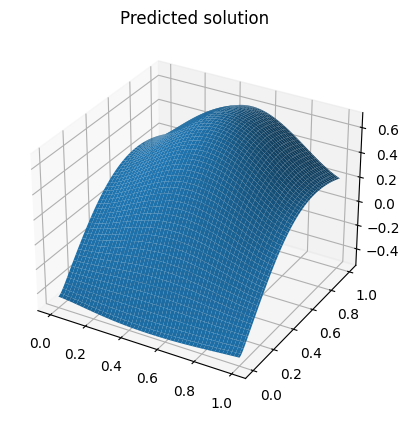

Train Epoch: 49 
Total Loss: 20.5037174225 	Criterion Loss: 9.2683296204 	Boundary Condition Loss 1.123539
Train Epoch: 49 
Total Loss: 21.7720108032 	Criterion Loss: 10.7128705978 	Boundary Condition Loss 1.105914
Train Epoch: 49 
Total Loss: 23.3995456696 	Criterion Loss: 12.9219369888 	Boundary Condition Loss 1.047761
Train Epoch: 49 
Total Loss: 23.4963645935 	Criterion Loss: 13.0958108902 	Boundary Condition Loss 1.040055

After Epoch 49, 	 Actual solution loss: 0.0680925448



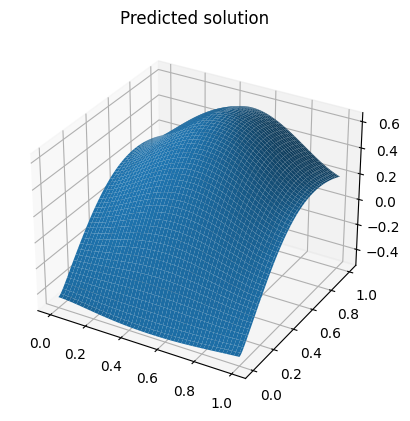

elapse time in parallel =  1877.5908641815186


In [6]:
epochs = 50
device = torch.device("cpu")

learning_rate = 1e-3
batch_flag = True
batch_size = 128

print(eps)
output,losses,errors = train(device,x,y,xb,yb,eps,learning_rate,epochs,batch_flag,batch_size)

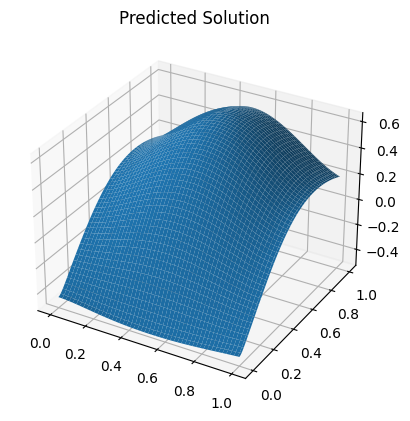

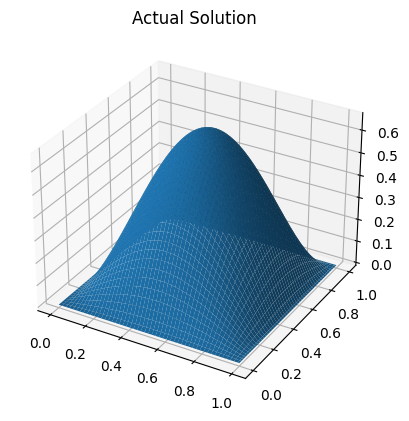

In [7]:
z = output.detach().numpy()
plot_graph(z,"Predicted Solution")
plot_graph(actual_soln(eps),"Actual Solution")

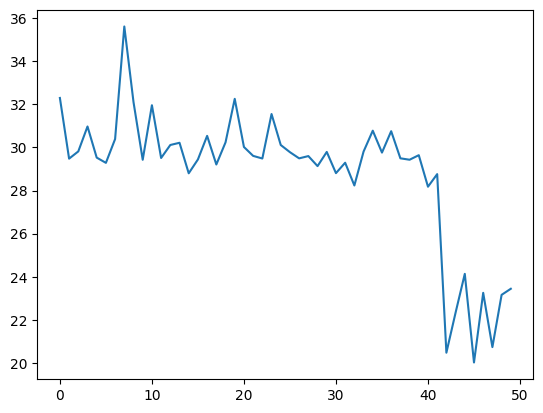

In [8]:
plt.plot(losses)
plt.show()